# **RECURRENT NEURAL NETWORK (RNN)**

## Initialize

In [1]:
import os
import io
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler

In [2]:
# set random seeds
np.random.seed(51)
tf.random.set_seed(51)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Dataset

### Create a synthetic dataset

**Helper functions**

In [3]:
def plot_ts_data(time, series, line_style='-', start=0, end=None, label=None):
    """
    Plots the graph for time series data
    """
    plt.plot(time[start:end], series[start:end], line_style, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)


def trend(time, slope=0):
    """
    Creates a line with slope.
    """
    return slope * time

def seasonal_pattern(season_time):
    """
    Creates an arbitrary pattern. You can change it.
    """
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """
    Creates a repititive pattern.
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """
    Creates white noise.
    """
    np.random.seed(seed)
    return np.random.randn(len(time)) * noise_level

**Create a series**

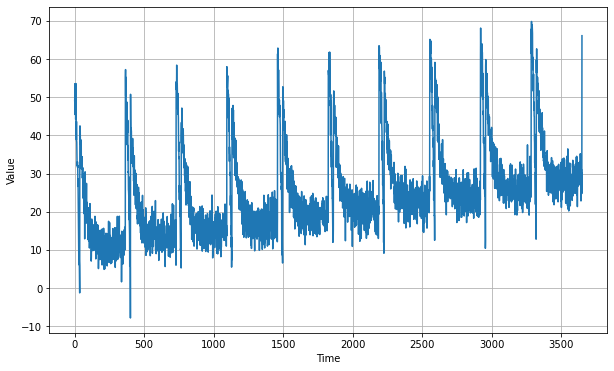

In [4]:
# inputs
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# create the series
series = baseline\
         + trend(time, slope) \
         + seasonality(time, period=365, amplitude=amplitude) \
         + noise(time, noise_level, seed=51)

# show the series in a graph
plt.figure(figsize=(10, 6))
plot_ts_data(time, series)
plt.show()

**Split the dataset**

In [5]:
# time point to split train and validation data
split_time = 3000

# training data
t_train = time[:split_time]    # time
x_train = series[:split_time]  # values

# validation data
t_valid = time[split_time:]    # time
x_valid = series[split_time:]  # values

# check dataset sizes
print(f'size - training: {len(x_train)}, validation: {len(x_valid)}')

size - training: 3000, validation: 651


**Windowed Dataset**

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None, shuffle=True):
    # convert to tfds
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # from the time-series data, iteratively extract data in rolling windows
    # window size = window_size (features) + 1 (label)
    # rolling window shifts 1 time step (shift=1)
    # if the window does not have enough data points, drop it (drop_remainder=True)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    # flat the window into chunks
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # shuffle the dataset
    # using 'shuffle_buffer' speeds up shuffling for large dataset
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # split features (all but the last data point) and labels (the last one)
    # iteratively return those as tuples
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # iteratively return data in a batch
    dataset = dataset.batch(batch_size).prefetch(1)

    return  dataset

# inputs
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# create windowed dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Evaluation Metrics

**Mean squarred error (MSE)**
- Use when large error is significantly more critical.

**Mean absolute error (MAE)**
- Use when errors are proportionally critical.

In [7]:
# function for calculating MSE
MSE = lambda actual, prediction: np.mean((actual - prediction)**2)
# function for calculating MAE
MAE = lambda actual, prediction: np.mean(abs(actual - prediction))

## Model

In [8]:
def build_model():
    # input layer
    input_tensor = Input(shape=[window_size])
    
    # expand the dimension
    x = Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_tensor)

    # hidden LSTM layers
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Bidirectional(LSTM(32))(x)

    # output layer
    x = Dense(1)(x)
    # scale up the output
    output_tensor = Lambda(lambda x: x * 10.)(x)

    # model
    model = tf.keras.Model(input_tensor, output_tensor)

    return model

# clear session
tf.keras.backend.clear_session()

# set random seeds
np.random.seed(51)
tf.random.set_seed(51)

# create a model
model = build_model()

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 20, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________

## Hyper-parameter Tuning
- Get an optimal learning rate.

In [9]:
# callback for learning rate scheduling
# schedule a learning rate for exponential increase
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

# compile
model.compile(
    optimizer=SGD(lr=1e-8, momentum=0.9),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

# train for 100 epochs
hist = model.fit(
    dataset,
    epochs=100,
    callbacks=[lr_schedule],
    verbose = 0
)

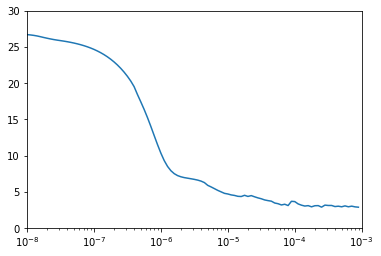

the learning rate with the minimum loss: 0.0008912509381337459


In [10]:
# learning rates
lrs = 1e-8 * 10 ** (np.arange(100) / 20)

# plot the learning rate vs. loss (MSE) graph
plt.figure()
plt.semilogx(lrs, hist.history['loss'])
plt.axis([1e-8, 1e-3, 0, 30])
plt.show()

# the learning rate with the minimum loss
idx = np.argmin(hist.history['loss'])
print('the learning rate with the minimum loss:', lrs[idx])

## Train

In [11]:
class SimpleVerbose(tf.keras.callbacks.Callback):
    """
    prints loss and metrics at certain frequency.
    """
    def __init__(self, freq=10, items=['loss']):
        super(SimpleVerbose, self).__init__()
        self.freq = freq
        self.items = items
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            print('Training started ...')
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.freq == 0:
            print(f"Epoch {epoch+1} ", end='')
            for item in self.items:
                print(f"- {item}: {logs.get(item):.4f} ", end='')
            print()

simple_verbose = SimpleVerbose(freq=20, items=['loss', 'mae'])

In [12]:
# clear session
tf.keras.backend.clear_session()

# set random seeds
np.random.seed(51)
tf.random.set_seed(51)

# create a new model
model = build_model()

# compile
model.compile(
    optimizer=SGD(lr=1e-5, momentum=0.9),
    loss='mse',
    metrics=['mae']
)

# train for 500 epochs
hist = model.fit(
    dataset,
    epochs=500,
    verbose = 0,
    callbacks=[simple_verbose]
)

Training started ...
Epoch 20 - loss: 22.7453 - mae: 3.1738 
Epoch 40 - loss: 21.2098 - mae: 3.0431 
Epoch 60 - loss: 20.9047 - mae: 3.0409 
Epoch 80 - loss: 20.2989 - mae: 2.9837 
Epoch 100 - loss: 19.7856 - mae: 2.9277 
Epoch 120 - loss: 19.7316 - mae: 2.9134 
Epoch 140 - loss: 19.8458 - mae: 2.9426 
Epoch 160 - loss: 20.0591 - mae: 2.9747 
Epoch 180 - loss: 19.2836 - mae: 2.8760 
Epoch 200 - loss: 19.3205 - mae: 2.8946 
Epoch 220 - loss: 19.6255 - mae: 2.9147 
Epoch 240 - loss: 19.1629 - mae: 2.8642 
Epoch 260 - loss: 18.8842 - mae: 2.8397 
Epoch 280 - loss: 18.8591 - mae: 2.8365 
Epoch 300 - loss: 19.8717 - mae: 2.9635 
Epoch 320 - loss: 19.1176 - mae: 2.8832 
Epoch 340 - loss: 18.6176 - mae: 2.8079 
Epoch 360 - loss: 18.7156 - mae: 2.8326 
Epoch 380 - loss: 18.5516 - mae: 2.8196 
Epoch 400 - loss: 18.9736 - mae: 2.8578 
Epoch 420 - loss: 18.6043 - mae: 2.8244 
Epoch 440 - loss: 18.6872 - mae: 2.8310 
Epoch 460 - loss: 18.4466 - mae: 2.7981 
Epoch 480 - loss: 18.5135 - mae: 2.7933 

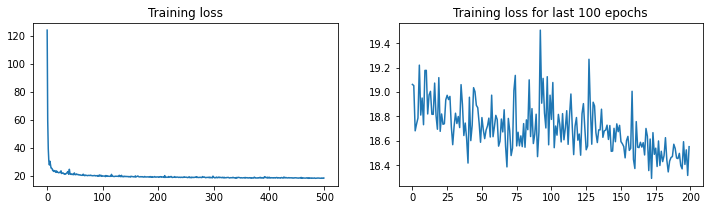

In [13]:
# plot the loss graph
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.title('Training loss')
plt.plot(hist.history['loss'])

plt.subplot(1, 2, 2)
plt.title('Training loss for last 100 epochs')
plt.plot(hist.history['loss'][-200:])

plt.show()

## Test

In [14]:
# generate inputs from validation data
inputs = []
for time in range(split_time-window_size, len(series) - window_size):
    inputs.append(series[time:time + window_size])

# get predictions
forecast = model.predict(np.array(inputs))[:, 0]

# evaluation metrics
print(f'MSE: {MSE(x_valid, forecast):.6f}')
print(f'MAE: {MAE(x_valid, forecast):.6f}')

MSE: 19.244924
MAE: 2.858731


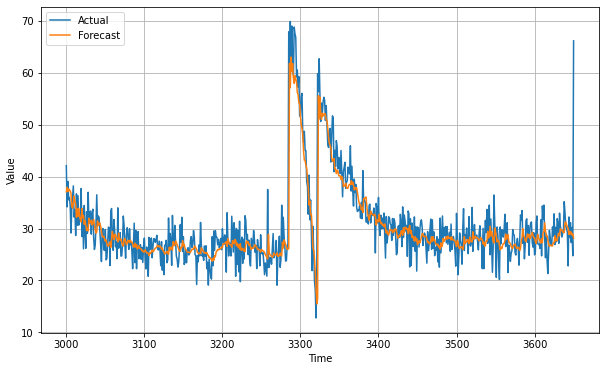

In [15]:
# compare in graph
plt.figure(figsize=(10, 6))

plt.plot(t_valid, x_valid, label='Actual')
plt.plot(t_valid, forecast, label='Forecast')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)

plt.show()